In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
import os, sys, warnings
from time import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt, ticker
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
class MLP(nn.Module):

    def __init__(self,  fc1_num, fc2_num, fc3_num, dropout_rate):
        super(MLP, self).__init__()
        self.fc1_num = fc1_num
        self.fc2_num = fc2_num
        self.fc3_num = fc3_num

        # 两个全连接层
        self.fc1 = nn.Linear(fc1_num, fc2_num) # 702 -> 30
        self.fc2 = nn.Linear(fc2_num, 1)
        # self.fc3 = nn.Linear(fc3_num, 1)# 30 -> 1
        # 激活函数
        self.relu = nn.ReLU()
        # dropout
        self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        # 初始化权重
        self._init_weights()

    def _init_weights(self):
        # 使用 xavier 的均匀分布对 weights 进行初始化
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        # 使用正态分布对 bias 进行初始化
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, data):
        data = self.flatten(data)
        data = self.fc1(data) # N*30
        data = self.relu(data)
        data = self.dropout(data)
        data = self.fc2(data)
        # data = self.relu(data)
        # data = self.dropout(data)
        # data = self.fc3(data)
        # 线性激活函数，无需再进行激活
        data = data.to(torch.float)

        return data


class FactorData():

    def __init__(self, train_x, train_y):
        self.len = len(train_x)
        self.x_data = train_x
        self.y_data = train_y

    def __getitem__(self, index):
        """
        指定读取数据的方式：根据索引 index 返回 dataset[index]

        """
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


In [3]:
def train_mlp(model, train_x, train_y, test_x, test_y, lr=1e-4, epoch=30, batch_size=1000, mom=0.9):
    # 1. 加载数据
    train_dataset = FactorData(train_x, train_y)
    test_dataset = FactorData(test_x, test_y)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # 2. 模型训练
    weight_list, bias_list = [], []
    for name, p in model.named_parameters():
        if 'bias' in name: 
            bias_list += [p] # 将所有的 bias 参数放入 bias_list 中
        else:
            weight_list += [p] # 将所有的 weight 参数放入 weight_list 中
    
    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    test_criterion = nn.L1Loss()

    optimizer = optim.RMSprop(
        [{'params': weight_list, 'weight_decay': 1e-5},
         {'params': bias_list, 'weight_decay': 0}],
        lr=lr,
        momentum=mom)
    
    train_loss_list = []
    test_loss_list = []
    best_test_epoch, best_test_loss = 0, np.inf
    seed = 0

    # 开始训练
    for epoch in range(1, epoch+1):
        # 测试模式
        test_loss = 0
        model.eval()
        test_batch_num = 0
        with torch.no_grad():
            for data, label in tqdm(test_loader, f'Epoch {epoch}-test ', leave=False):
                test_batch_num += 1
                data, label = data.to(torch.float), label.to(torch.float)
                # 得到测试集的预测值
                y_pred = model(data)
                # 计算损失
                loss = test_criterion(y_pred, label)
                # 将损失值加入到本轮测试的损失中
                test_loss += loss.item()
    
        # 在训练集中训练模型
        # .train() 参考 https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
        # .zero_grad() 参考 https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        train_loss = 0
        model.train()  
        train_batch_num = 0
        for data, label in tqdm(train_loader, f'Epoch {epoch}-train', leave=False):
            train_batch_num += 1
            # 准备数据
            data, label = data.to(torch.float), label.to(torch.float)
            # 得到训练集的预测值
            out_put = model(data)
            # 计算损失
            loss = criterion(out_put, label)
            # 将损失值加入到本轮训练的损失中
            train_loss += loss.item()
            # 梯度清零
            optimizer.zero_grad() 
            # 反向传播求解梯度
            loss.backward()
            # 更新权重参数
            optimizer.step()

        train_loss_list.append(train_loss/train_batch_num)
        test_loss_list.append(test_loss/test_batch_num)

    return model, train_loss_list, test_loss_list 

In [4]:
train_csv = "/home/lishi/projects/Competition/kaggle_2023/data/train_full_features.parquet"

df = pd.read_parquet(train_csv)
df = df.drop(columns=['row_id', 'time_id'])
df['imbalance_buy_sell_flag'] = df['imbalance_buy_sell_flag'].replace({-1: 0, 1: 1})

print(df.shape)
print(f"Trading days: {df['date_id'].nunique()}")
print(f"Stocks: {df['stock_id'].nunique()}")
    
prices =  ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
category = ["stock_id", "seconds_in_bucket", 'imbalance_buy_sell_flag', 'stock_label']

ta_indicators = ['ema', 'rsi', 'cci', 'mfi', 'ad_osc', 'macd', 'macdhist', 'macdsignal']

feature_cols = [x for x in df.columns if x not in ['target', 'date_id', 'row_id']+ta_indicators]

feature_cols = [x for x in feature_cols if 'target' not in x]

print("Number of features:", len(feature_cols))
print("Number of category features:", len(category))


(5237892, 305)
Trading days: 481
Stocks: 200
Number of features: 293
Number of category features: 4


In [16]:
stock_label = [1, 2]
sub_df = df[df['stock_label'].isin(stock_label)].copy()
sub_df.reset_index(drop=True, inplace=True)

print(sub_df.columns.tolist())

group_keys = ['stock_id', 'seconds_in_bucket']

shifts_list = [ sub_df.groupby(group_keys)[['target', 'wap', 'volume']].shift(x).add_prefix(f'prev_{x}_') for x in range(1, 6) ]
daily_shifts = pd.concat([sub_df] + shifts_list, axis=1)
daily_shifts.fillna(0, inplace=True)

feature_cols += [x for x in daily_shifts.columns if x.startswith('prev_')]
print("Number of features:", len(feature_cols))

# daily_shifts.head()

print(f"Number of stocks in label {stock_label}: {sub_df['stock_id'].nunique()}")


['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'target', 'stock_label', 'volume', 'mid_price', 'liquidity_imbalance', 'matched_imbalance', 'size_imbalance', 'imbalance_intensity', 'matched_intensity', 'price_spread', 'market_urgency', 'depth_pressure', 'price_pressure', 'imbalance_with_flag', 'far_price_near_price_imbalance', 'reference_price_ask_price_imbalance', 'reference_price_bid_price_imbalance', 'reference_price_wap_imbalance', 'ask_price_bid_price_imbalance', 'ask_price_wap_imbalance', 'bid_price_wap_imbalance', 'mean_reference_price', 'median_reference_price', 'std_reference_price', 'min_reference_price', 'max_reference_price', 'mean_far_price', 'median_far_price', 'std_far_price', 'min_far_price', 'max_far_price', 'mean_near_price', 'median_near_price', 'std_near_price', 'min_near_price', 'max_near_price', 'mean_ask_

In [17]:
stock_label = [1, 2]
sub_df = df[df['stock_label'].isin(stock_label)].copy()
sub_df.reset_index(drop=True, inplace=True)

test_date = np.random.choice(480, 48)

train_df = daily_shifts[~daily_shifts["date_id"].isin(test_date)]
test_df = daily_shifts[daily_shifts["date_id"].isin(test_date)]

print(train_df[feature_cols].shape, test_df[feature_cols].shape)

scale_col = [x for x in feature_cols if x not in category]

scaler = StandardScaler()
train_df[scale_col] = scaler.fit_transform(train_df[scale_col])
test_df[scale_col] = scaler.transform(test_df[scale_col])


(1877808, 308) (185625, 308)


In [18]:
model_name = f"mlp_no_ta_add_daily_{len(feature_cols)}_label_{'-'.join([str(x) for x in stock_label])}"
save_dir = f"/home/lishi/projects/Competition/kaggle_2023/data/mlp_models/{model_name}"
scaler_file = f"{save_dir}/{model_name}_scaler.pkl"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Best test loss: 8.290013083178012
Best test epoch: 1
Fianl test loss: 8.290085662063674


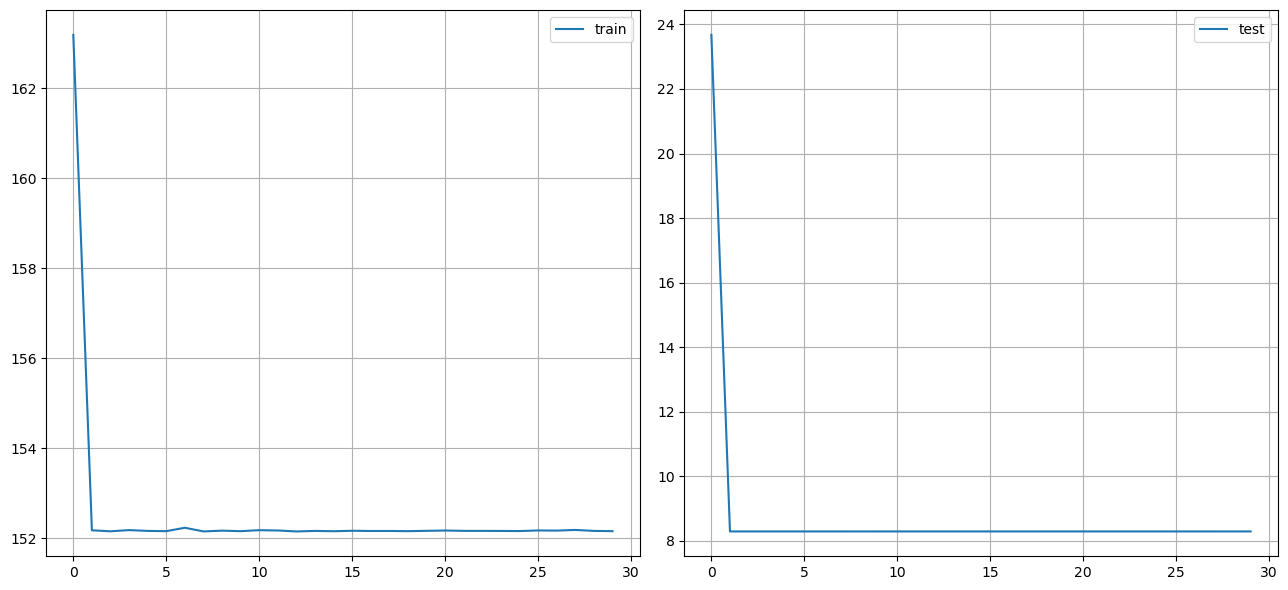

In [9]:
mlp = MLP(fc1_num=len(feature_cols), fc2_num=40, fc3_num=0, dropout_rate=0.2)

mlp, train_loss_list, test_loss_list = train_mlp(
    mlp, 
    train_df[feature_cols].values, train_df['target'].values, 
    test_df[feature_cols].values, test_df['target'].values, 
    lr=1e-4, 
    epoch=30, 
    batch_size=1000, 
    mom=0.9)

print(f"Best test loss: {np.min(test_loss_list)}")
print(f"Best test epoch: {np.argmin(test_loss_list)}")
print(f"Fianl test loss: {test_loss_list[-1]}")

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
axes[0].plot(train_loss_list, label='train')
axes[1].plot(test_loss_list, label='test')
for ax in axes:
    ax.legend()
    ax.grid()
fig.tight_layout()
plt.show()


In [10]:
import lightgbm as lgb

In [19]:
lgb_params = {
        'boosting_type': 'gbdt',
        'learning_rate': 0.015, #0.009,#0.018,
        'max_depth': 12,#9,
        'n_estimators': 800,#600,
        'num_leaves': 1024,#440,
        'objective': 'mae',
        'random_state': 42,
        'reg_alpha': 0.01,
        'reg_lambda': 0.01,
        'early_stopping_rounds': 50,
        'num_threads': 16,
        'importance_type': 'gain',
        'verbose': -1,
        }

lgb_model = lgb.LGBMRegressor(**lgb_params)

lgb_model.fit(
        train_df[feature_cols], 
        train_df['target'],
        eval_set=[(test_df[feature_cols], test_df['target'])],
        feature_name = feature_cols,
        categorical_feature = category,
        callbacks=[lgb.callback.log_evaluation(period=100)],
        )


[100]	valid_0's l1: 8.25333
[200]	valid_0's l1: 8.21846
[300]	valid_0's l1: 8.20534
[400]	valid_0's l1: 8.19634
[500]	valid_0's l1: 8.19091
[600]	valid_0's l1: 8.18761
[700]	valid_0's l1: 8.18472
[800]	valid_0's l1: 8.18261


LGBMRegressor(early_stopping_rounds=50, importance_type='gain',
              learning_rate=0.015, max_depth=12, n_estimators=800,
              num_leaves=1024, num_threads=16, objective='mae', random_state=42,
              reg_alpha=0.01, reg_lambda=0.01, verbose=-1)

In [23]:
print("LightGBM model training completed!")
print(f"Best iteration: {lgb_model.best_iteration_}")
print(f"Best score: {lgb_model.best_score_['valid_0']['l1']}")
print(f"Final score: {lgb_model.score(test_df[feature_cols], test_df['target'])}")
print(f"Number of iterations: {lgb_model.n_estimators_}")


LightGBM model training completed!
Best iteration: 796
Best score: 8.182571757270507
Final score: 0.05292601605117497
Number of iterations: 796


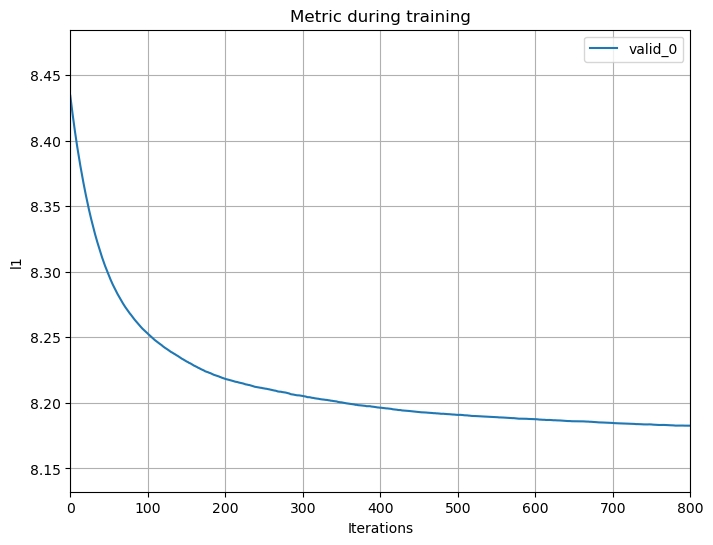

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
lgb.plot_metric(lgb_model, ax=ax)
plt.show()

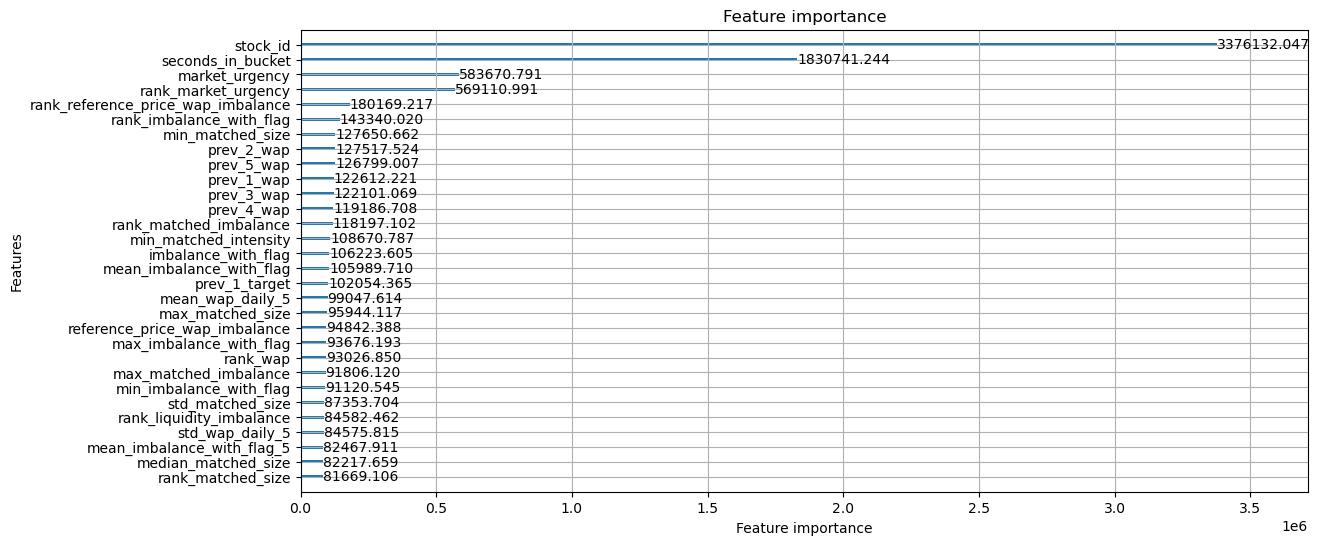

In [22]:
fig, ax = plt.subplots(figsize=(13, 6))
lgb.plot_importance(lgb_model, ax=ax, max_num_features=30)
plt.show()